# Property description analysis

This notebook mostly exists to analysis the contents of the properties in the valuer general.

## Initialise database client

Initialise the database client

In [1]:
from lib.service.database import DatabaseService
from lib.service.database.defaults import DB_INSTANCE_MAP

db = DatabaseService.create(DB_INSTANCE_MAP[1], 1)
await db.wait_till_running()

dbname=gnaf_db port=5434 user=postgres host=localhost password=throwAwayPassword


## Create some helper functions

- `get_the_data`, this really just wraps calls to `pd.read_sql`, mostly boilerplate

In [2]:
import pandas as pd
from pprint import pprint
from sqlalchemy import text

def get_the_data(query, params=None):
    engine = db.engine()
    return pd.read_sql(text(query), engine, params=params)

## SQL Boilerplate

We'll use this to fetch different stuff from the database.

In [3]:
def strata_items(limit, offset):
    return get_the_data("""
      SELECT * FROM nsw_lrs.legal_description_by_strata_lot 
      OFFSET   :offset
       LIMIT   :limit
    """, params={ 'offset': offset, 'limit': limit })

def non_strata_items(limit, offset):
    return get_the_data("""
      SELECT * FROM nsw_lrs.legal_description 
      OFFSET   :offset
       LIMIT   :limit
    """, params={ 'offset': offset, 'limit': limit })

def non_strata_item_by_id(ids):
    return get_the_data("""
      SELECT * FROM nsw_lrs.legal_description 
       WHERE property_id IN :ids
    """, params={ 'ids': ids })

def non_strata_item_containing(text, limit, offset):
    return get_the_data("""
      SELECT * FROM nsw_lrs.legal_description 
       WHERE legal_description ~ :text
      OFFSET   :offset
       LIMIT   :limit
    """, params={ 'offset': offset, 'limit': limit,  'text': text })

## Introspect the property description

Here we are just seeing which property descriptions seem to contain content that is abit weird.

In [4]:
from lib.pipeline.nsw_lrs.property_description import parse_property_description

rows = non_strata_items(10, 0)

weird = []
for i, row in rows.iterrows():
    desc = rows.loc[i, 'legal_description']
    remaining, expanded = parse_property_description(desc)
    
    if remaining:
        pprint({
            'id': int(rows.loc[i, 'property_id']),
            'description': desc,
            'remaining': remaining,
            # 'expanded': expanded,
        })
        weird.append(desc)
        
if len(weird) > 0:
    pprint(weird)

display(rows.iloc[:50])

,source_id,effective_date,legal_description_id,legal_description,legal_description_kind,property_id
0,1593,2024-11-01,1,261/1153831,> 2004-08-17,2937805
1,11334,2024-11-01,2,"3, 4/213495",> 2004-08-17,763771
2,19313,2024-11-01,3,23/806666,> 2004-08-17,22230
3,23756,2024-11-01,4,1/1245358,> 2004-08-17,4155240
4,24095,2024-11-01,5,199/1057816,> 2004-08-17,3026131
5,25456,2024-11-01,6,3/1130995,> 2004-08-17,3472769
6,27883,2024-11-01,7,2/1035960,> 2004-08-17,2876342
7,29059,2024-11-01,8,PT 4/1067380,> 2004-08-17,3406061
8,39668,2024-11-01,9,"1, 2/456723 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, ...",> 2004-08-17,4186562
9,42606,2024-11-01,10,11/789409,> 2004-08-17,2529615


In [5]:
property_descriptions = non_strata_item_by_id((
    '623846', # 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, CP/SP10943
    '1878087', # B/100895 6, PT 20/755520 Enclosure Permit 510145
    '1878096', # 1, 2, 3/133592 99/755520 153/755529 Enclosure Permit 50192
    '1878175', # PT 1/628296 1/705069
    '2682966', # 15/1073508 Mineral Claim 42522R Western Land Lease 14691
    '3625326', # Forest Permit OCP100015
    '3821010', # 1, 3, 4/366686 1, 2/435063 18, 70/755529 1, 2, 3, 4/1088131 1/1166347
    '4483251', # 1, 2/199140 2/530749 82, 120, 181/756909 27, 57, 134, PT 135, 136, 137, 190, 202, PT 210, PT 211/756913
    '3625277',
))

for i, row in property_descriptions.iterrows():
    desc = property_descriptions.loc[i, 'legal_description']
    remaining, expanded = parse_property_description(desc)
    pprint({
        'description': desc,
        'remaining': remaining,
        'expanded': expanded,
    })

property_descriptions

{'description': '1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, '
                '18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, CP/SP10943',
 'expanded': [LandParcel(id='1/SP10943', part=False),
              LandParcel(id='2/SP10943', part=False),
              LandParcel(id='3/SP10943', part=False),
              LandParcel(id='4/SP10943', part=False),
              LandParcel(id='5/SP10943', part=False),
              LandParcel(id='6/SP10943', part=False),
              LandParcel(id='7/SP10943', part=False),
              LandParcel(id='8/SP10943', part=False),
              LandParcel(id='9/SP10943', part=False),
              LandParcel(id='10/SP10943', part=False),
              LandParcel(id='11/SP10943', part=False),
              LandParcel(id='12/SP10943', part=False),
              LandParcel(id='13/SP10943', part=False),
              LandParcel(id='14/SP10943', part=False),
              LandParcel(id='15/SP10943', part=False),
              LandParcel(id=

,source_id,effective_date,legal_description_id,legal_description,legal_description_kind,property_id
0,446737,2024-11-01,521737,"1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",> 2004-08-17,623846
1,273097,2024-11-01,1451226,"B/100895 6, PT 20/755520 Enclosure Permit 510145",> 2004-08-17,1878087
2,26139940,2020-11-04,5396707,"B/100895 6, PT 20/755520",> 2004-08-17,1878087
3,273102,2024-11-01,45559,"1, 2, 3/133592 99/755520 153/755529 Enclosure ...",> 2004-08-17,1878096
4,10050185,2005-04-13,3411203,"1, 2, 3/133592 99, /755520 153, /755529",> 2004-08-17,1878096
5,20412778,2015-08-24,4705361,"1, 2, 3/133592 99/755520 153/755529",> 2004-08-17,1878096
6,26092634,2019-12-06,5390455,"1, 2, 3/133592 99/755520 153/755529 Enclosure ...",> 2004-08-17,1878096
7,274740,2024-11-01,118473,PT 1/628296 1/705069,> 2004-08-17,1878175
8,9775518,2005-11-28,3376575,PT 1/628296 1/705069 WB 016565,> 2004-08-17,1878175
9,2677681,2024-11-01,1460917,15/1073508 Mineral Claim 42522R Western Land L...,> 2004-08-17,2682966


# Distribution of data

  effective_date
0     2024-11-01
1     2024-11-01
2     2024-11-01
3     2024-11-01
4     2024-11-01 5911181


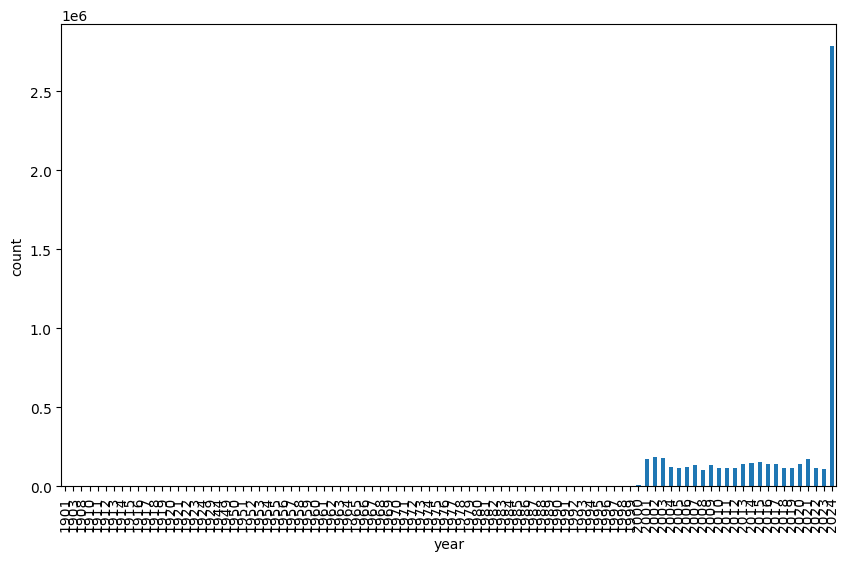

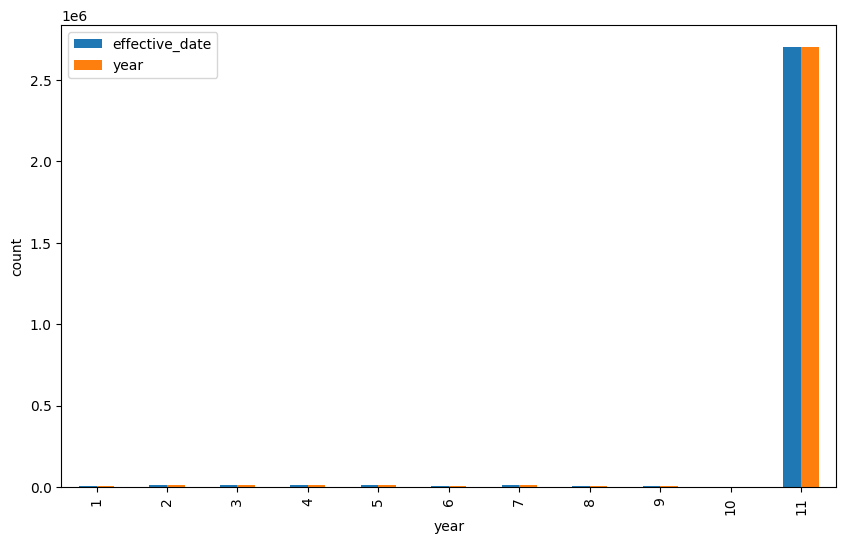

In [6]:
import matplotlib.pyplot as plt

def plot_hist(df, xlabel, ylabel, title, **args):
    df.plot(**args)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    

df = get_the_data("""
    SELECT effective_date FROM nsw_lrs.legal_description
     where effective_date > '1900-01-01'
       and effective_date < '2024-12-01'
""")

print(df.head(), len(df))

df['effective_date'] = pd.to_datetime(df['effective_date'])
df["year"] = df["effective_date"].dt.year

plot_hist(df.groupby('year').size(), 'year', 'count', '', kind='bar', figsize=(10, 6))

df = df[df['year'] == 2024]
plot_hist(df.groupby(df['effective_date'].dt.month).count(), 'year', 'count', '', kind='bar', figsize=(10, 6)) 



In [7]:
get_the_data("""
    WITH ranked_data AS (
        SELECT
            effective_date,
            NTILE(8) OVER (ORDER BY effective_date) AS segment
        FROM
            nsw_lrs.legal_description
    )
    SELECT
        segment,
        MIN(effective_date) AS start_date,
        MAX(effective_date) AS end_date,
        COUNT(*) AS count_in_segment
    FROM
        ranked_data
    GROUP BY
        segment
    ORDER BY
        segment
""")

,segment,start_date,end_date,count_in_segment
0,1,0016-08-10,2005-07-12,738912
1,2,2005-07-12,2011-09-06,738912
2,3,2011-09-06,2016-12-20,738912
3,4,2016-12-20,2022-06-08,738912
4,5,2022-06-08,2024-11-01,738912
5,6,2024-11-01,2024-11-01,738912
6,7,2024-11-01,2024-11-01,738912
7,8,2024-11-01,2031-09-30,738912


In [8]:
get_the_data("""
    SELECT d.* FROM nsw_lrs.legal_description d
     where effective_date >= '2024-11-01' and effective_date < '2025-01-01'
""")

,source_id,effective_date,legal_description_id,legal_description,legal_description_kind,property_id
0,1593,2024-11-01,1,261/1153831,> 2004-08-17,2937805
1,11334,2024-11-01,2,"3, 4/213495",> 2004-08-17,763771
2,19313,2024-11-01,3,23/806666,> 2004-08-17,22230
3,23756,2024-11-01,4,1/1245358,> 2004-08-17,4155240
4,24095,2024-11-01,5,199/1057816,> 2004-08-17,3026131
...,...,...,...,...,...,...
2703547,29623843,2024-11-07,5846814,4060/261629,> 2004-08-17,2311934
2703548,29624310,2024-11-06,5846886,235/25462,> 2004-08-17,2390105
2703549,29624926,2024-11-04,5846970,10/17428,> 2004-08-17,2531633
2703550,29626083,2024-11-04,5847153,4/16907,> 2004-08-17,1333816


# Anonomlies

## Descriptions containing `;`

In [9]:
from lib.pipeline.nsw_lrs.property_description import parse_property_description

rows = non_strata_item_containing(';', limit=20, offset=0)

weird = []
for i, row in rows.iterrows():
    desc = rows.loc[i, 'legal_description']
    print(int(rows.loc[i, 'property_id']), desc)

display(rows.iloc[:])

3599739 12/1161984  (part Wildlife Refuge No.362); Enclosure Permit 22427
4363908 7309/1169890 5997/1205342 6058/1205343 6871/1205344 3578/1205346 PART; and crown roads Licence 623573
4362972 PART; crown roads Licence 623573
1245733 PT 1/209581 PT 7321/1166558 Subsurface Area = 53.41ha; Surface Area = 12.25 ha Mining Lease 739
3407923 122/42056 2/718634 2/733835 58, 69, 132/751078 1, 2/1022767 1, 4, 5/1080470 for grazing(crown land bounded by 105/751078, 1,2/1080470;parcel west of 96/751078) Licence 344585 Licence 405371
2473913 1/1062221 (being at Tarana in two parts:- Pumphouse (2042.5 m2);  Reservoir 1/1062221 and Easement) Railway Land Lease 151311
970426 PT 7093/93909 AND NSW MARITIME LEASE SHOWN IN PLAN No WL2025; BEING THE SITE OF NORTHBRIDGE SAILING CLUB, RAMP, PONTOON, CONCRETE PILES AND CHAIN STAYS. PART LOT 7093 DP 93909 HAS AN UNSPECIFIED AREA.
3665826 1/787417 13, 14, 15/1225577 Mining Lease 1620 - Total area 365.2 ha (Surface 83.04ha,  Sub-surface 282.2 ha) within Part Lo

,source_id,effective_date,legal_description_id,legal_description,legal_description_kind,property_id
0,72701,2024-11-01,1216341,12/1161984 (part Wildlife Refuge No.362); Enc...,> 2004-08-17,3599739
1,609300,2024-11-01,527679,7309/1169890 5997/1205342 6058/1205343 6871/12...,> 2004-08-17,4363908
2,1118752,2024-11-01,896234,PART; crown roads Licence 623573,> 2004-08-17,4362972
3,133993,2024-11-01,1457119,PT 1/209581 PT 7321/1166558 Subsurface Area = ...,> 2004-08-17,1245733
4,58983,2024-11-01,1673289,"122/42056 2/718634 2/733835 58, 69, 132/751078...",> 2004-08-17,3407923
5,651728,2024-11-01,1873093,1/1062221 (being at Tarana in two parts:- Pump...,> 2004-08-17,2473913
6,731485,2024-11-01,1868525,PT 7093/93909 AND NSW MARITIME LEASE SHOWN IN ...,> 2004-08-17,970426
7,595301,2024-11-01,2200777,"1/787417 13, 14, 15/1225577 Mining Lease 1620 ...",> 2004-08-17,3665826
8,704887,2024-11-01,2432001,"42, PT 57, PT 58, PT 59, PT 60, PT 61/754940 a...",> 2004-08-17,3838002
9,487744,2024-11-01,2486533,252/531397 Council lease (34sqm. - STONE SEAWA...,> 2004-08-17,748784
